In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None


import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from imblearn.over_sampling import SMOTE

### Read and Explore Data

In [48]:
label_path = "jbookRDTELabel.csv"
jbook = pd.read_csv(label_path)
jbook.head()

,Text,AI,AI Stack
0,This PE supports basic research at the Army la...,0,NaN
1,This Project funds basic research within the A...,0,NaN
2,"Funds basic research in chemistry, biology, bi...",0,NaN
3,Funds basic research in weapons component deve...,0,NaN
4,Funds basic research in ground vehicle technol...,0,NaN


In [49]:
jbook = pd.read_csv(label_path) 

In [50]:
jbook.isna().sum()

Text         171
AI             0
AI Stack    6268
dtype: int64

In [51]:
jbook.dropna(subset=['Text'], inplace=True)

In [6]:
jbook.isna().sum()

Text           0
AI             0
AI Stack    6097
dtype: int64

In [7]:
jbook.shape

(7734, 3)

In [8]:
jbook.AI.value_counts(normalize=True)

0    0.788208
1    0.211792
Name: AI, dtype: float64

In [9]:
ai_stack = jbook[jbook.AI == 1]['AI Stack']

ai_stack.value_counts()

Autonomy                          463
Machine Learning                  214
Modeling                          208
Human AI Interaction              161
Decision Support                  134
Devices                           112
Massive Data Management           109
Autonomy; Human AI Interaction     77
Planning & Acting                  77
Planning and Acting                57
Ethics                             14
Human Ai Interaction                6
Computing                           3
Compute                             1
Name: AI Stack, dtype: int64

In [10]:
ai_stack.replace('Human Ai Interaction', 'Human AI Interaction', inplace=True)
ai_stack.replace('Planning and Acting', 'Planning & Acting', inplace=True)
ai_stack.replace('Compute', 'Computing', inplace=True)

ai_stack.value_counts()

Autonomy                          463
Machine Learning                  214
Modeling                          208
Human AI Interaction              167
Decision Support                  134
Planning & Acting                 134
Devices                           112
Massive Data Management           109
Autonomy; Human AI Interaction     77
Ethics                             14
Computing                           4
Name: AI Stack, dtype: int64

<AxesSubplot:ylabel='AI Stack'>

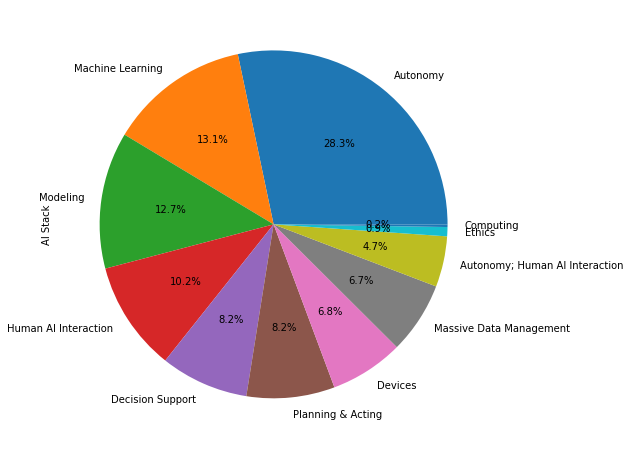

In [12]:
pie, ax = plt.subplots(figsize=[12,8])
ai_stack.value_counts().plot.pie(autopct="%.1f%%")
ax.set_ylabel('')

### Select and Group Relevant Features

In [52]:
X = jbook.Text
y = jbook.AI

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [12]:
print(y_train.value_counts())
print(y_test.value_counts())

0    4877
1    1310
Name: AI, dtype: int64
0    1219
1     328
Name: AI, dtype: int64


In [ ]:
# use oversampling to balance AI labels
# smote = SMOTE()
# X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
# print(y_train_sm.value_counts())

# Build a RNN Model

#### Prep data for Modeling

In [108]:
# Import the tools we will need from keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics

In [79]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [80]:
# Use the tokenizer to transform the text in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [81]:
# What do these sequences look like?
len(X_train_seq[0])

380

In [117]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 300)
X_test_seq_padded = pad_sequences(X_test_seq, 300)

In [83]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0, 6171,  198,
       3982, 1631, 1631,  320,   34, 4359,  644,  143,  105, 1172,   26,
        230,  434, 1631,  423,   20,  230, 3525,   13,   65,   99,   17,
         20,  313, 2313, 2185,   28,  239,    2,  136,  588,   34,    6,
        960,    3,  297, 1172,   77, 6172, 7433,    1, 2227, 3054, 8536,
          5,    2, 2501,    4,  134,   61, 4359,  644,  143,   13,   10,
         25,    4,  548,    1, 2502, 1071, 1648, 1863, 2092,  239, 1287,
        334,   62,   14,    6,    2,  229,    1, 2819,  703,    3, 2733,
          1,  804,    5,  394,  391,  244,   11, 1153,  423,    1, 2313,
       1062,    4, 1172,   77, 6172, 7433,  194,    2,  321,   87,    4,
        134,   61,    1, 2734, 4153,   61,  230, 3525,  395,  230, 2819,
          1,  740,  703,    3,  692, 6807, 5270,  258,    3, 8537,  295,
       2313,    1, 2735,  230, 3525,   66,  101,  5

## Tuning using Keras Tuner

In [118]:
def tune_model(hp):

    # Number of 1st hidden layer neurons
    units = hp.Int('units',        #<- Number of neurons
                   min_value = 8,  #<- min value
                   max_value = 64, #<- max value
                   step = 8)

    # Tuning activation function for 1st hidden layer
    activation = hp.Choice('activation', #<- Activation function
                           [             #<- Types of activation functions
                               'relu',
                               'tanh',
                               'sigmoid'
                           ])

    dropout_1 = hp.Float('dropout_1',
                         min_value = 0.0,
                         max_value = 0.5,
                         default = 0.25,
                         step = 0.05)

    # Tuning optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    # Tuning learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    model = keras.Sequential() 

    model.add(keras.layers.Embedding(len(tokenizer.index_word)+1, units))
    
    model.add(keras.layers.LSTM(units))

    # Tuning number of neurons in 2nd hidden layer
    model.add(keras.layers.Dense(units = units,
                                 activation = activation))

    # Tuning rate hyperparameter of dropout layer
    model.add(Dropout(rate = dropout_1))

    # Add output layer
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))

    # Compile model.
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = METRICS)

    return model

In [119]:
# Select metrics

METRICS = [
tf.keras.metrics.TruePositives(name='tp'),
tf.keras.metrics.FalsePositives(name='fp'),
tf.keras.metrics.TrueNegatives(name='tn'),
tf.keras.metrics.FalseNegatives(name='fn'),
tf.keras.metrics.BinaryAccuracy(name='accuracy'),
tf.keras.metrics.Precision(name='precision'),
tf.keras.metrics.Recall(name='recall'),
tf.keras.metrics.AUC(name='auc')
]

In [120]:
# Define the tuner

MAX_TRIALS = 10
EXECUTIONS_PER_TRIAL = 5
tuner = RandomSearch(
    tune_model,
    objective = 'val_accuracy',
    max_trials = MAX_TRIALS,
    executions_per_trial = EXECUTIONS_PER_TRIAL,
    directory = 'final_tuned_model',
    project_name = 'final_tuned_model',
    seed = 1
)

INFO:tensorflow:Reloading Oracle from existing project final_tuned_model\final_tuned_model\oracle.json


In [121]:
#View search space summary

tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [122]:
# Tuning the model

tuner.search(x=X_train_seq_padded,
            y=y_train,
            verbose=1,
            epochs=25,
            validation_data=(X_test_seq_padded, y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |16                |?                 
activation        |relu              |?                 
dropout_1         |0.1               |?                 
optimizer         |adam              |?                 
learning_rate     |0.0001            |?                 

Epoch 1/5
218/218 - 16s - loss: 0.4460 - tp: 199.0000 - fp: 99.0000 - tn: 5387.0000 - fn: 1275.0000 - accuracy: 0.8026 - precision: 0.6678 - recall: 0.1350 - auc: 0.7513 - val_loss: 0.3152 - val_tp: 100.0000 - val_fp: 43.0000 - val_tn: 567.0000 - val_fn: 64.0000 - val_accuracy: 0.8618 - val_precision: 0.6993 - val_recall: 0.6098 - val_auc: 0.9067
Epoch 2/5
218/218 - 15s - loss: 0.2797 - tp: 1046.0000 - fp: 380.0000 - tn: 5106.0000 - fn: 428.0000 - accuracy: 0.8839 - precision: 0.7335 - recall: 0.7096 - auc: 0.9209 - val_loss: 0.3304 - val_tp: 79.0000 - val_fp: 24.0000 - val_tn: 586.0000 - val_fn: 85.0000 - val_accuracy: 0.

In [123]:
optimal_params = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
optimal_params

{'units': 16,
 'activation': 'relu',
 'dropout_1': 0.45,
 'optimizer': 'rmsprop',
 'learning_rate': 0.001}

In [124]:
# Define and compile optimized model

def create_optimized_model(units,
                           activation,
                           dropout_1,
                           optimizer,
                           learning_rate,
                           dropout_seed = 1):

    # Set up model
    model = Sequential()
    
    model.add(Embedding(len(tokenizer.index_word)+1, units))
    
    model.add(LSTM(units))

    # Tuning number of neurons in 2nd hidden layer
    model.add(Dense(units = units,
                    activation = activation))

    if dropout_1 is not None:
        model.add(Dropout(rate = dropout_1, seed = dropout_seed))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = METRICS)
    return model

In [131]:
# Fit the optimized model and visualize results

# Create and compile the optimized model
tb_model = create_optimized_model(**optimal_params)

tb_model = tb_model.fit(X_train_seq_padded,
                        y_train, 
                        validation_data = (X_test_seq_padded, y_test),
                        epochs = 25,
                        verbose = 1)         

Epoch 1/25
218/218 [==============================] - 18s 65ms/step - loss: 0.4890 - tp: 109.6256 - fp: 54.7078 - tn: 3339.1096 - fn: 790.2648 - accuracy: 0.8085 - precision: 0.6663 - recall: 0.1678 - auc: 0.7482 - val_loss: 0.3503 - val_tp: 55.0000 - val_fp: 21.0000 - val_tn: 589.0000 - val_fn: 109.0000 - val_accuracy: 0.8320 - val_precision: 0.7237 - val_recall: 0.3354 - val_auc: 0.8977
Epoch 2/25
218/218 [==============================] - 16s 72ms/step - loss: 0.3329 - tp: 371.5251 - fp: 113.9315 - tn: 2656.9087 - fn: 377.3425 - accuracy: 0.8570 - precision: 0.7876 - recall: 0.4517 - auc: 0.9002 - val_loss: 0.3181 - val_tp: 105.0000 - val_fp: 40.0000 - val_tn: 570.0000 - val_fn: 59.0000 - val_accuracy: 0.8721 - val_precision: 0.7241 - val_recall: 0.6402 - val_auc: 0.9095
Epoch 3/25
218/218 [==============================] - 19s 85ms/step - loss: 0.2963 - tp: 547.8311 - fp: 181.2100 - tn: 2572.3927 - fn: 218.2740 - accuracy: 0.8862 - precision: 0.7662 - recall: 0.7083 - auc: 0.9232 -

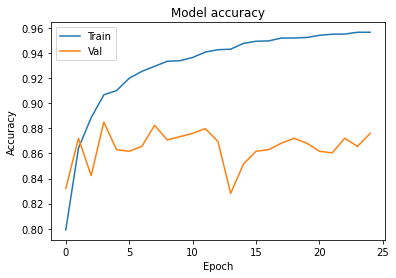

In [132]:
# Plot training & validation accuracy values
plt.plot(tb_model.history['accuracy'])    #<- accuracy scores
plt.plot(tb_model.history['val_accuracy'])#<- get val accuracy scores from dictionary
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

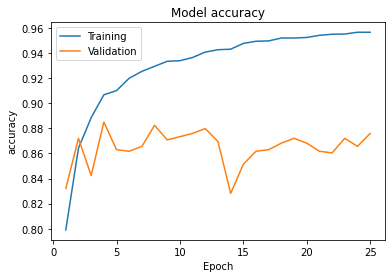

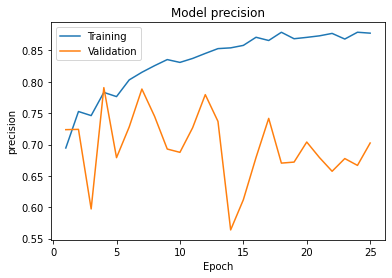

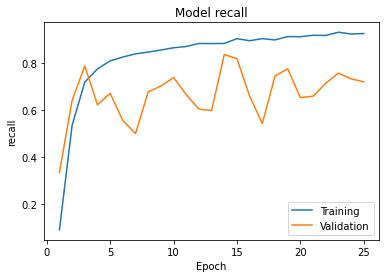

In [133]:
# Plot the evaluation metrics by each epoch for the model
for i in ['accuracy', 'precision', 'recall']:
    acc = tb_model.history[i]
    val_acc = tb_model.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training')
    plt.plot(epochs, val_acc, label='Validation')
    plt.title(f'Model {i}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{i}')
    plt.legend()
    plt.show()